**Table of contents**<a id='toc0_'></a>    
- [Create a table from files in object storage](#toc1_)    
- [Add a table from an upstream dataset in the pipeline](#toc2_)    
- [Create a table with enriched data views](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [ ]:
import dlt
from pyspark.sql.functions import *


In [ ]:
import os

os.environ["UNITY_CATALOG_VOLUME_PATH"] = "/Volumes/my_catalog/my_schema/my_volume/"
os.environ["DATASET_DOWNLOAD_URL"] = "https://health.data.ny.gov/api/views/jxy9-yhdk/rows.csv"
os.environ["DATASET_DOWNLOAD_FILENAME"] = "rows.csv"

dbutils.fs.cp(f"{os.environ.get('DATASET_DOWNLOAD_URL')}", f"{os.environ.get('UNITY_CATALOG_VOLUME_PATH')}{os.environ.get('DATASET_DOWNLOAD_FILENAME')}")


True

# <a id='toc1_'></a>[Create a table from files in object storage](#toc0_)

In [ ]:
@dlt.table(
  comment="Popular baby first names in New York. This data was ingested from the New York State Department of Health."
)
def baby_names_raw():
  df = spark.read.csv(f"{os.environ.get('UNITY_CATALOG_VOLUME_PATH')}{os.environ.get('DATASET_DOWNLOAD_FILENAME')}", header=True, inferSchema=True)
  df_renamed_column = df.withColumnRenamed("First Name", "First_Name")
  return df_renamed_column


Name,Type
Year,int
First_Name,string
County,string
Sex,string
Count,int


# <a id='toc2_'></a>[Add a table from an upstream dataset in the pipeline](#toc0_)

In [ ]:
@dlt.table(
  comment="New York popular baby first name data cleaned and prepared for analysis."
)
@dlt.expect("valid_first_name", "First_Name IS NOT NULL")
@dlt.expect_or_fail("valid_count", "Count > 0")
def baby_names_prepared():
  return (
    dlt.read("baby_names_raw")
      .withColumnRenamed("Year", "Year_Of_Birth")
      .select("Year_Of_Birth", "First_Name", "Count")
  )


Name,Type
Year_Of_Birth,int
First_Name,string
Count,int


# <a id='toc3_'></a>[Create a table with enriched data views](#toc0_)

In [ ]:
@dlt.table(
  comment="A table summarizing counts of the top baby names for New York for 2021."
)
def top_baby_names_2021():
  return (
    dlt.read("baby_names_prepared")
      .filter(expr("Year_Of_Birth == 2021"))
      .groupBy("First_Name")
      .agg(sum("Count").alias("Total_Count"))
      .sort(desc("Total_Count"))
      .limit(10)
  )


Name,Type
First_Name,string
Total_Count,bigint


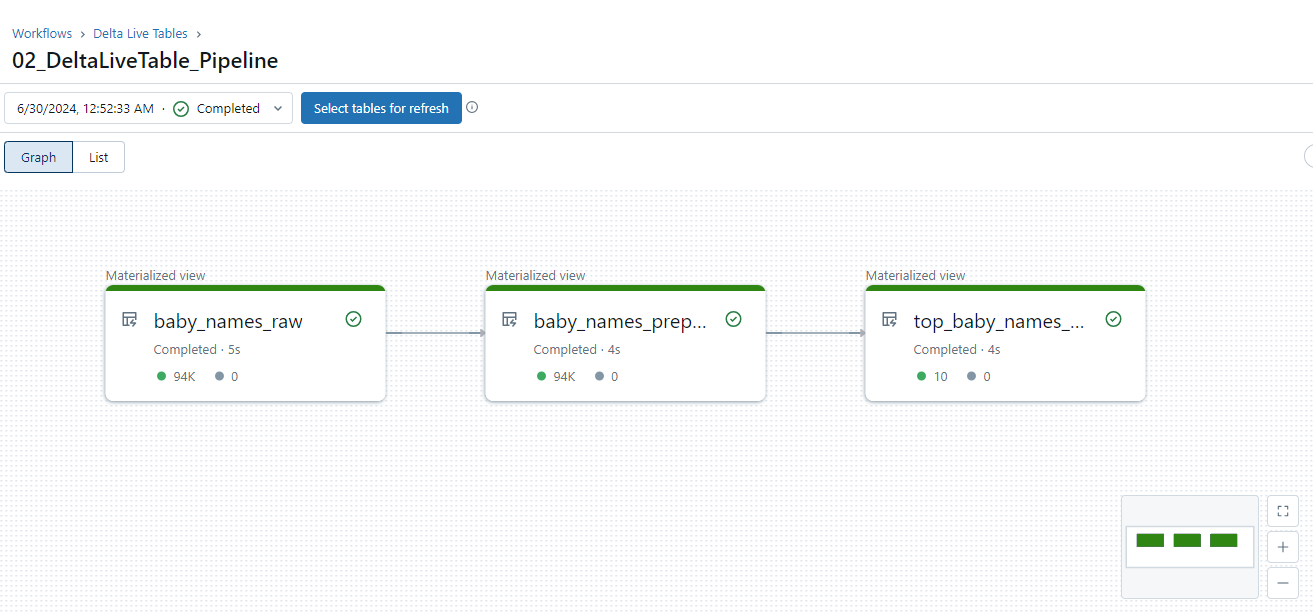

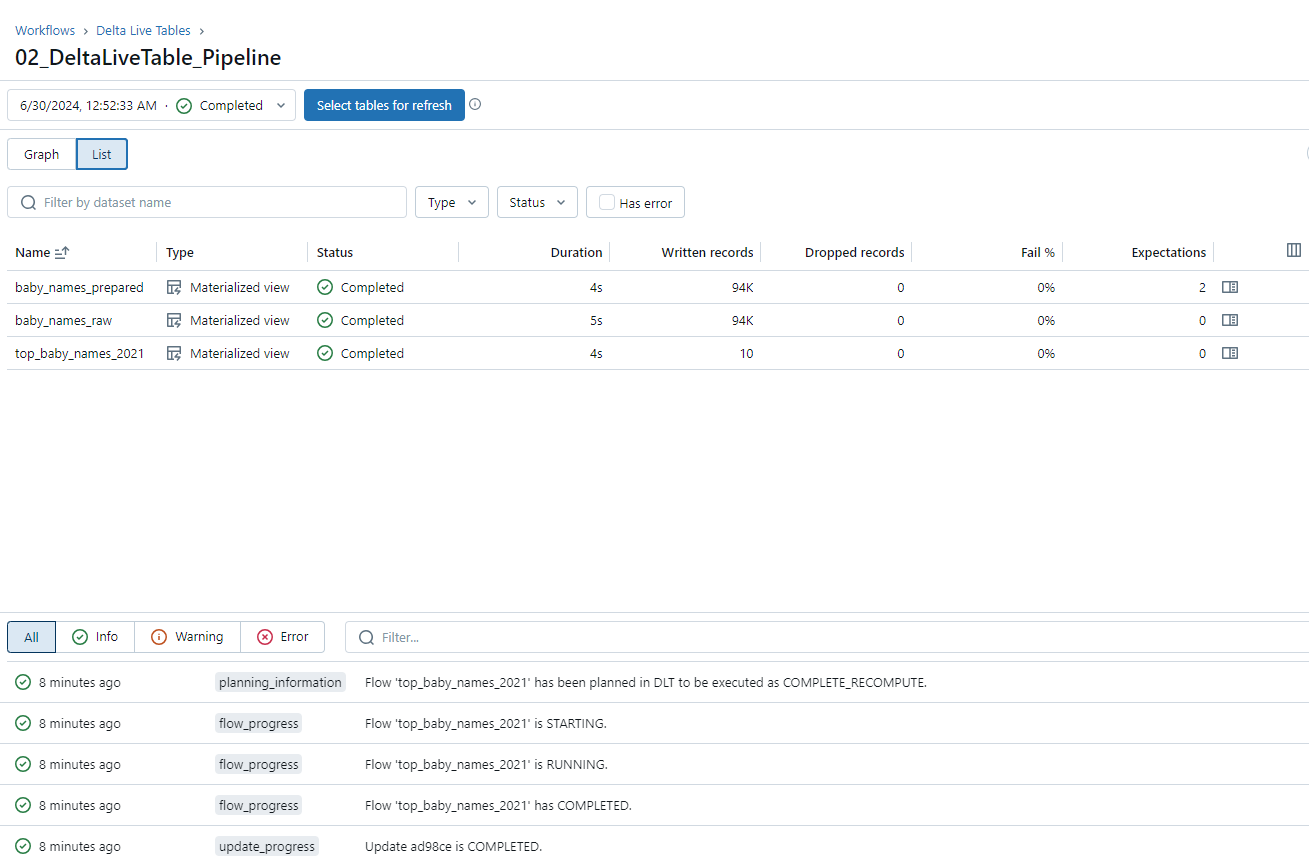